In [1]:
from data.dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd


from models.lstm import Generator, Discriminator
from tools.viz import plot_values


class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('./data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        
        self.ngpu = 1
        
        # Train params
        self.lr = 0.0002
        self.epochs = 500
        
opts = Options()

# Setup Dataset

In [2]:
dataset = MULTI_VP_Dataset(opts.data_path, method='multi')
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=opts.shuffle, 
                        num_workers=opts.nworkers, drop_last=opts.drop_last)

Inputs shape: torch.Size([11771, 3, 640])
Inputs head:
 tensor([[[0.0000, 0.5056, 0.5021,  ..., 0.6109, 0.6104, 0.6109],
         [0.9515, 0.9519, 0.9519,  ..., 0.9420, 0.9418, 0.9419],
         [0.3328, 0.3329, 0.3296,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6256, 0.6264,  ..., 0.7085, 0.7099, 0.7078],
         [0.9538, 0.9542, 0.9542,  ..., 0.9553, 0.9547, 0.9556],
         [0.4049, 0.4064, 0.4038,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7326, 0.7339,  ..., 0.6905, 0.6922, 0.6905],
         [0.9585, 0.9590, 0.9586,  ..., 0.9565, 0.9563, 0.9571],
         [0.4705, 0.4738, 0.4702,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.3909, 0.3892,  ..., 0.6672, 0.6692, 0.6682],
         [0.9503, 0.9508, 0.9509,  ..., 0.9603, 0.9598, 0.9605],
         [0.2583, 0.2594, 0.2558,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6372, 0.6386,  ..., 0.6540, 0.6556, 0.6558],
         [0.9569, 0.9571, 0.9567,  ..., 0.9554, 0.9549, 0.9558],
         [0.4113, 0.4140, 

# Models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [4]:
netG = Generator(
    input_size=dataset.inputs.shape[2],
    hidden_size=128,
    output_size=dataset.inputs.shape[2],
    device=device
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[2],
    hidden_size=64,
    device=device
).to(device)

print(netG, netD)

Generator(
  (lstm0): LSTM(640, 128, batch_first=True)
  (lstm1): LSTM(128, 256, batch_first=True)
  (lstm2): LSTM(256, 512, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=640, bias=True)
    (1): Tanh()
  )
) Discriminator(
  (lstm): LSTM(640, 64, batch_first=True)
  (lstm1): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


# Training

In [5]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

seq_len = dataset.inputs.shape[1]


In [6]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = x.to(device)
        
        b_size = real.size(0)
        label = torch.full((b_size, seq_len, 1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, _ = netD(real)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn_like(real, device=device)
        # Generate fake batch with G
        fake, _ = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, _ = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, _ = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opts.epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2),
                  end='\r', flush=True)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

Starting Training Loop...


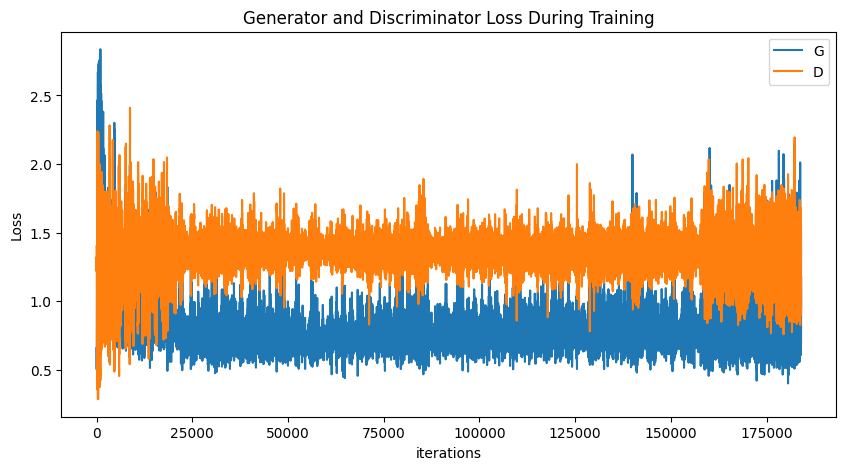

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
lines = []

# generate random samples
for i in range(100):
    noise = torch.randn((1, 3, 640), device=device)
    fake, _ = netG(noise)
    fake = fake.flatten(end_dim=1).detach().cpu().numpy()
    lines.append(fake)

lines = np.array([np.concatenate(values, axis=0) for values in lines])
lines.shape

fake_data = pd.DataFrame(lines)
inv_fake_data = dataset.scaler.inverse_transform(fake_data)
inv_fake_data = pd.DataFrame(inv_fake_data)

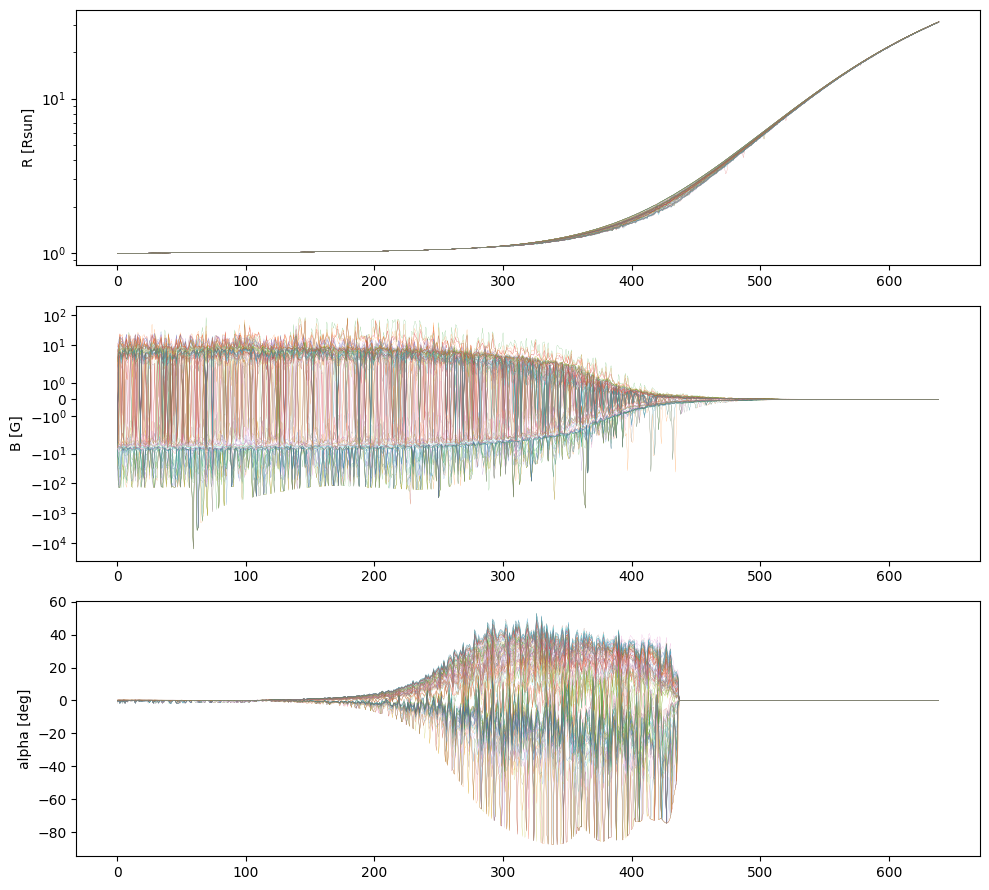

In [10]:
plot_values(inv_fake_data, scales={'B [G]':'symlog', 'alpha [deg]': 'linear'})